### **opencv的几何变换**  

学习目标：学习对图像进行各种几个变换，例如**移动，旋转，仿射变换，透视变换**等。

本节的主要函数:  
（1）计算矩阵函数：**cv2.getPerspectiveTransform（接收4个坐标）**  和 **cv2.getAffineTransform（接收3个坐标）**  
（2）图像变换函数：**cv2.warpAffine（接收2x3矩阵）** 和 **cv2.warpPerspective（接收3x3矩阵）**

In [1]:
# 导入包
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 构建展示函数
def show(img,title = 'Test'):
    cv2.imshow(title,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#重载自己的图像大小调整函数
def my_resize(img,height = 0,width = 0):
    if(height):
        temp_height = img.shape[0]
        my_ratio = height/temp_height
        img = cv2.resize(img,(0,0),fx = my_ratio,fy = my_ratio)
    if(width):
        temp_width = img.shape[1]
        my_ratio = width/temp_width
        img = cv2.resize(img,(0,0),fx = my_ratio,fy = my_ratio)
    return img

**一：图像的扩展缩放**

In [2]:
# 图像的扩展缩放

img = cv2.imread('images/cat.jpg')

# 设置转换因子进行缩放
img_big = cv2.resize(img,None,fx = 2,fy = 2,interpolation = cv2.INTER_CUBIC)
show(img_big,title = 'Big_factor')
print(img_big.shape)

# 直接指定大小缩放
img_big = cv2.resize(img,(1000,828))
show(img_big,title = 'Big_set_size')

(828, 1000, 3)


**二：图像的平移**

利用的是 $2\times 3$ 矩阵M,其中:

$M = \begin{bmatrix} 1 & 0 & tx \\ 0 & 1 & ty \\ \end{bmatrix}$

tx，ty 表示的是 x 方向与 y 方向的偏移量  

这时输入的坐标点变为了 $ 3 \times 1$，即 $ Y = \begin{bmatrix} x \\ y \\ 1 \\ \end{bmatrix} $

具体实现：可以使用 Numpy 数组构建这个矩阵（**数据类型一定要是浮点数np.float32**），然  
后把它传给函数 **cv2.warpAffine()**。

In [3]:
# 平移变化

img = cv2.imread('images/cat.jpg')
M = np.array([[1,0,100],[0,1,50]],dtype = np.float64)

# 第一个参数为待变化图像，第二个为变换矩阵，第三个为变换后图像大小：None保持不变
img_move = cv2.warpAffine(img,M,None)
show(img_move,title = 'Move')

**三：图像的旋转**

利用的是一个旋转矩阵M，大小为 $ 2 \times 3 $，其中

$ M = \begin{bmatrix}
\cos{\theta} & -\sin{\theta} & tx \\
\sin{\theta} & \cos{\theta} & ty \\
\end{bmatrix} $

实际上opencv是这样操作的:

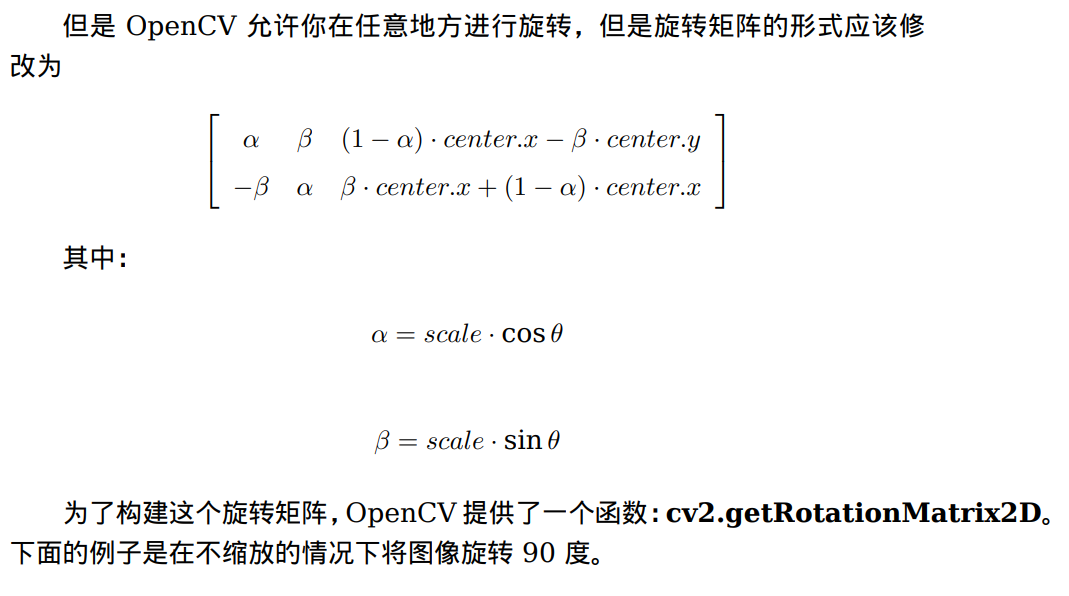

In [4]:
# 进行图像的旋转

img = cv2.imread('images/cat.jpg')

# 手动构建矩阵
M = np.array([[0,-1,0],[1,0,0]],dtype = np.float32) # 注意浮点数数据类型
img_revolve = cv2.warpAffine(img,M,None)
show(img_revolve,title = 'My_revlolve')

# 发现自己的旋转矩阵是以（0，0）（线性变换不变原点性）为旋转点的，不能满足要求

# 利用cv2内置函数cv2.getRotationMatrix2D()

rows = img.shape[0]
cols = img.shape[1]

# 第一个参数为旋转中心，第二个参数为旋转角度（角度制），第三个参数为缩放因子
M = cv2.getRotationMatrix2D((cols/2,rows/2),90,0.6)
img_revolve = cv2.warpAffine(img,M,None)
show(img_revolve,title = 'Matrix_revolve')


**四：图像的仿射变换**

具体做法：  

在仿射变换中，原图中所有的平行线在结果图像中同样平行。为了创建这个矩阵我们需要从原图像中找到 **三个非共线点** 以及他们在输出图像中的位置。  
然后**cv2.getAffineTransform** 会创建一个 2x3 的矩阵，最后这个矩阵会被传给函数 **cv2.warpAffine** 。

In [5]:
# 进行仿射变换

img = cv2.imread('images/cat.jpg')
pts1 = np.array([[100,50],[200,50],[300,100]],np.float32) # 构建一组点

# 展示点在图中的位置信息
img_temp = img.copy()
for i in range(len(pts1)):
    x = np.int64(pts1[i][0])
    y = np.int64(pts1[i][1])
    img_temp = cv2.circle(img_temp,(x,y),2,(0,0,255),5)
show(img_temp)

# 构建想要变换到的位置
pts2 = np.array([[169,70],[220,60],[320,110]],np.float32)
M = cv2.getAffineTransform(pts1,pts2) # 计算有pts1 到 pts2的变换矩阵，必须保证坐标为浮点数cv_F32

# 进行图像的矩阵运算
img_temp = cv2.warpAffine(img_temp,M,None)
show(img_temp,title = 'Affine_Transform')

**五：图像的透视变换**

具体做法:

对于视角变换，我们需要一个 3x3 变换矩阵。在变换前后直线还是直线。  
要构建这个变换矩阵，你需要在输入图像上找 **4 个点（不共线）**，以及他们在输出图  
像上对应的位置。这四个点中的任意三个都不能共线。这个变换矩阵可以有  
函数 **cv2.getPerspectiveTransform** 构建。然后把这个矩阵传给函数 **cv2.warpPerspective**。

In [6]:
# 进行图像的透视变换
paper = my_resize(cv2.imread('images/my_paper2.jpg'),height = 500)

# 之前做过项目知道了4个点（按鸟瞰逆时针顺序）
pts1 = np.array([[ 32 , 57],
[167 ,321],
[347 ,236],
[205 , 34]],np.float32)

# （鸟瞰顺序）点的可视化
img_temp = paper.copy()
for i in range(len(pts1)):
    x = np.int64(pts1[i][0])
    y = np.int64(pts1[i][1])
    img_temp = cv2.circle(img_temp,(x,y),2,(0,0,255),5)
    show(img_temp,title = 'Paper_points_show')

# 构建想要变换到的坐标
pts2 = np.array([[0,0],
[0,800],
[500,800],
[500,0]],np.float32)

# cv2计算变换矩阵
M = cv2.getPerspectiveTransform(pts1,pts2)
paper_cvt = cv2.warpPerspective(img_temp,M,(500,800))
show(paper_cvt,title = 'Perspective_cvt')
